# GlueStick Image Matching Demo 🖼️💥🖼️


In this python notebook we show how to obtain point and line matches using GlueStick. GlueStick is a unified pipeline that uses a single GNN to process both types of features and predicts coherent point and line matched that help each other in the matching process.

![](https://iago-suarez.com/gluestick/static/images/method_overview2.svg)

If you use this python notebook please cite our work:

> Pautrat, R.* and Suárez, I.* and Yu, Y. and Pollefeys, M. and Larsson, V. (2023). "GlueStick: Robust Image Matching by Sticking Points and Lines Together". ArXiv preprint.

In [9]:
# # Download the repository
# !git clone https://github.com/cvg/GlueStick.git
# %cd GlueStick

In [10]:
# Install requirements
# !pip install -r requirements.txt

Download the pre-trained model

In [11]:
# !wget https://github.com/cvg/GlueStick/releases/download/v0.1_arxiv/checkpoint_GlueStick_MD.tar -P resources/weights

In [12]:
from os.path import join

import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt


from gluestick import batch_to_np, numpy_image_to_torch, GLUESTICK_ROOT
from gluestick.drawing import plot_images, plot_lines, plot_color_line_matches, plot_keypoints, plot_matches
from gluestick.models.two_view_pipeline import TwoViewPipeline

Define the configuration and model that we are going to use in our demo:

In [13]:
MAX_N_POINTS, MAX_N_LINES = 1000, 300

# Evaluation config
conf = {
    'name': 'two_view_pipeline',
    'use_lines': True,
    'extractor': {
        'name': 'wireframe',
        'sp_params': {
            'force_num_keypoints': False,
            'max_num_keypoints': MAX_N_POINTS,
        },
        'wireframe_params': {
            'merge_points': True,
            'merge_line_endpoints': True,
        },
        'max_n_lines': MAX_N_LINES,
    },
    'matcher': {
        'name': 'gluestick',
        'weights': str(GLUESTICK_ROOT / 'resources' / 'weights' / 'checkpoint_GlueStick_MD.tar'),
        'trainable': False,
    },
    'ground_truth': {
        'from_pose_depth': False,
    }
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipeline_model = TwoViewPipeline(conf).to(device).eval()
pipeline_model

TwoViewPipeline(
  (extractor): SPWireframeDescriptor(
    (sp): SuperPoint(
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (convPb): Conv2d(256, 65, kernel_size=(1, 1), str

In [14]:
# Load input images
import sys

img_path0 = "/media/colin/DATA/exp_office_cieling/matlab_clahe2_rect_appx/1697668704578459277.png"
img_path1 = "/media/colin/DATA/exp_office_cieling/matlab_clahe2_rect_appx/1697668704645165036.png"

img_path0 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/1689805041743999958.png"
# img_path0 = "/media/colin/box_data/ir_data/nuance_data/kri_night/cam_3/matlab_clahe2/1689819946857000113.png"
img_path1 = "/media/colin/box_data/ir_data/nuance_data/kri_night/cam_3/matlab_clahe2/1689819945923000097.png"
# img_path1 = "/media/colin/box_data/ir_data/nuance_data/kri_night/cam_3/matlab_clahe2/1689819953789999962.png"

# img_path0 = "/media/colin/box_data/ir_data/nuance_data/kri_night/cam_3/matlab_clahe2/1689819868072999954.png"
# img_path1 = "/media/colin/box_data/ir_data/nuance_data/kri_night/cam_3/matlab_clahe2/1689819868105999947.png"

#debug have kp off edge of image
# img_path0 = "/media/colin/box_data/ir_data/nuance_data/columbus_garrage_day_night/garrage_roof_nuance_jul17_5pm_2/cam_3/matlab_clahe2_rect/1689627759802999973.png"
# img_path1 = "/media/colin/box_data/ir_data/nuance_data/columbus_garrage_day_night/garrage_roof_nuance_jul17_5pm_2/cam_3/matlab_clahe2_rect/1689627759869999886.png"


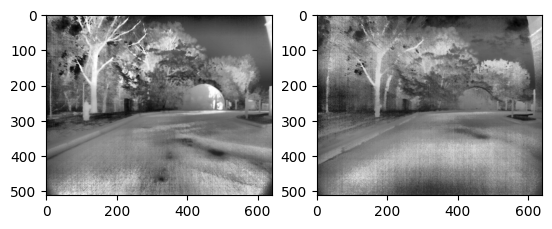

In [15]:
img = cv2.imread(img_path0, cv2.IMREAD_GRAYSCALE)

gray0 = cv2.imread(img_path0, 0)
gray1 = cv2.imread(img_path1, 0)

# Plot them using matplotlib
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(gray0, cmap='gray')
axarr[1].imshow(gray1, cmap='gray')

In [16]:
# Convert images into torch and execute GlueStick💥

torch_gray0, torch_gray1 = numpy_image_to_torch(gray0), numpy_image_to_torch(gray1)
torch_gray0, torch_gray1 = torch_gray0.to(device)[None], torch_gray1.to(device)[None]
# x = {'image0': torch_gray0, 'image1': torch_gray1}
# pred = pipeline_model(x)

#proposed c++ workflow
#run extractor separately on each image as they come in
im0_pred = pipeline_model._extract_single_forward(torch_gray0)
#run run on next image
im1_pred = pipeline_model._extract_single_forward(torch_gray1)
#get numpy versions of everything
print("before conversion")
print(im0_pred["num_junctions"])
for key in im0_pred.keys():
    print("key: {} type: {}, shape {}".format(key, type(im0_pred[key]), im0_pred[key].shape if type(im0_pred[key]) == torch.Tensor else -1))
im0_pred = batch_to_np(im0_pred)
im1_pred = batch_to_np(im1_pred)
#send to c++ side

################## c++ stuff #############################

#get 2 sets of extracted data back from c++ side

print("during conversion")
#send the numpy stuff back to the gpu
for pred in (im0_pred, im1_pred):
    for key in pred.keys():
        d = pred[key]
        if not type(d) == list:
            try :
                d = torch.from_numpy(d).unsqueeze_(0).to(device)
            except TypeError:
                d = torch.tensor([d], dtype = torch.int64)
                # print("this key: {}".format(key))
        else:
            # print(key)
            d = torch.Size(d)
        # print("key: {} type: {}".format(key, type(d)))
        pred[key] = d

print("after conversion")
print(im0_pred["num_junctions"])
for key in im0_pred.keys():
    print("key: {} type: {}, shape {}".format(key, type(im0_pred[key]), im0_pred[key].shape if type(im0_pred[key]) == torch.Tensor else -1))
# print(type(im0_pred["kps"]))

#prepare the model for mat
pred = pipeline_model._merge_kp_pred(im0_pred, im1_pred)
print("pred")
print(pred.keys())
# pred['image_size0'] = torch_gray0.shape
# pred['image_size1'] = torch_gray1.shape
pred = pipeline_model._match_forward(pred)



# print(pred.keys())

before conversion
tensor([168])
key: keypoints type: <class 'torch.Tensor'>, shape torch.Size([1, 838, 2])
key: keypoint_scores type: <class 'torch.Tensor'>, shape torch.Size([1, 838])
key: descriptors type: <class 'torch.Tensor'>, shape torch.Size([1, 256, 838])
key: pl_associativity type: <class 'torch.Tensor'>, shape torch.Size([1, 838, 838])
key: num_junctions type: <class 'torch.Tensor'>, shape torch.Size([1])
key: lines type: <class 'torch.Tensor'>, shape torch.Size([1, 94, 2, 2])
key: orig_lines type: <class 'torch.Tensor'>, shape torch.Size([1, 94, 2, 2])
key: lines_junc_idx type: <class 'torch.Tensor'>, shape torch.Size([1, 94, 2])
key: line_scores type: <class 'torch.Tensor'>, shape torch.Size([1, 94])
key: valid_lines type: <class 'torch.Tensor'>, shape torch.Size([1, 94])
key: image_size type: <class 'torch.Size'>, shape -1
during conversion
after conversion
tensor([168])
key: keypoints type: <class 'torch.Tensor'>, shape torch.Size([838, 2])
key: keypoint_scores type: <cla

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
print(f"Detected Keypoints: {pred['keypoints0'].shape[1]} img1, {pred['keypoints1'].shape[1]} img2")
print(f"Detected Lines: {pred['lines0'].shape[1]} img1, {pred['lines1'].shape[1]} img2\n")
print(f"Matched {(pred['matches0'] >= 0).sum()} points and {(pred['line_matches0'] >= 0).sum()} lines")

Detected Keypoints: 838 img1, 543 img2
Detected Lines: 94 img1, 32 img2

Matched 199 points and 16 lines


Show some matches

In [ ]:


pred = batch_to_np(pred)


In [ ]:

kp0, kp1 = pred["keypoints0"], pred["keypoints1"]
desc0, desc1 = pred['descriptors0'].T, pred['descriptors1'].T


m0 = pred["matches0"]
m1 = pred["matches1"]
m0_scores = pred['match_scores0']
m1_scores = pred['match_scores1']
# print(m0_scores[:20])
# print(m1_scores[:20])
lines_junc_idx0, lines_junc_idx1 = pred['lines_junc_idx0'], pred['lines_junc_idx1']

line_seg0, line_seg1 = pred["lines0"], pred["lines1"]
line_matches = pred["line_matches0"]
# print(m0_scores.shape)
valid_matches = m0 != -1
# print(valid_matches.shape)
match_indices = m0[valid_matches]
match_scores = m0_scores[valid_matches]
matched_kps0 = kp0[valid_matches]
matched_kps1 = kp1[match_indices]
# print("m1")
# print(m1.shape)
valid_matches1 = m1 != -1
# print(valid_matches1.shape)
# print(m1_scores.shape)
match_indices1 = m1[valid_matches1]
match_scores1 = m1_scores[valid_matches1]
matched_kps0_1 = kp0[match_indices1]
matched_kps1_1 = kp1[valid_matches1]
# print(match_scores[:10])
# print(match_scores1[:10])

#reorder kpts
sort_idxs = np.argsort(-match_scores)
matched_kps0 = matched_kps0[sort_idxs]
matched_kps1 = matched_kps1[sort_idxs]
matched_scores_sorted = match_scores[sort_idxs]

sort_idxs_1 = np.argsort(-match_scores1)
matched_kps0_1 = matched_kps0_1[sort_idxs_1]
matched_kps1_1 = matched_kps1_1[sort_idxs_1]
matched_scores_sorted_1 = match_scores1[sort_idxs_1]

# print(matched_scores_sorted[:10])
# print(matched_scores_sorted_1[:10])
# print(matched_kps0[:10])
# print(matched_kps0_1[:10])

# matched_scores_sorted = match_scores[sort_idxs]
line_scores = pred['line_scores0']
valid_matches = line_matches != -1
match_indices = line_matches[valid_matches]
matched_lines0 = line_seg0[valid_matches]
matched_lines1 = line_seg1[match_indices]
matched_lines_junc_idx0 = lines_junc_idx0[valid_matches]
matched_line_scores = line_scores[valid_matches]
#reorder lines
line_sort_idxs = np.argsort(-matched_line_scores)
matched_lines0 = matched_lines0[line_sort_idxs]
matched_lines1 = matched_lines1[line_sort_idxs]
matched_line_scores_sorted = matched_line_scores[line_sort_idxs]
print("lines")
print(matched_line_scores.shape)
print(matched_line_scores_sorted[:10])
print(matched_lines0.shape)
print(matched_lines1[:2])

# print(matched_lines0)
# print(matched_lines0)

def parse_lines(kps, lines, desc):
    '''Turns out to just duplicate the index provided by "lines_junc_idx0"'''
    line_kp_idx = np.empty(lines.shape[:2], dtype = int)
    # line_descs = []
    line_descs = np.empty((len(lines), 2, desc.shape[-1]), dtype = np.float32)

    for i, line in enumerate(lines):
        #seach for line end point in kps
        line_end_pt_0 = line[0]
        line_end_pt_1 = line[1]

        kp_match_0 = np.logical_and.reduce(kps == line_end_pt_0, axis = -1)
        kp_match_1 = np.logical_and.reduce(kps == line_end_pt_1, axis = -1)

        end_pt_desc_0 = desc[kp_match_0].reshape(-1)
        end_pt_desc_1 = desc[kp_match_1].reshape(-1)
        assert(len(end_pt_desc_0) == 256)
        assert(len(end_pt_desc_1) == 256)
        line_descs[i,0,:] = end_pt_desc_0
        line_descs[i,1,:] = end_pt_desc_1

        end_pt_0_kp_idx = np.nonzero(kp_match_0)[0]
        end_pt_1_kp_idx = np.nonzero(kp_match_1)[0]
        assert(len(end_pt_0_kp_idx) == 1)
        assert(len(end_pt_1_kp_idx) == 1)
        # print(end_pt_0_kp_idx)
        # print(end_pt_1_kp_idx)
        line_kp_idx[i,0] = end_pt_0_kp_idx[0]
        line_kp_idx[i,1] = end_pt_1_kp_idx[0]
        # raise 

    return line_kp_idx, line_descs

def get_line_descriptors(descriptors, line_junc_idx):
    '''return array of line descriptors'''
    line_descs = np.empty((line_junc_idx.shape[0], line_junc_idx.shape[1], 256), dtype = np.float32)
    for i, line in enumerate(line_junc_idx):
        line_descs[i,0,:] = descriptors[line[0]]
        line_descs[i,1,:] = descriptors[line[1]]
    return line_descs

def get_line_kp(keypoints, line_junc_idx):
    '''for debugging'''
    line_descs = np.empty((line_junc_idx.shape[0], line_junc_idx.shape[1], 2), dtype = np.float32)
    for i, line in enumerate(line_junc_idx):
        line_descs[i,0,:] = keypoints[line[0]]
        line_descs[i,1,:] = keypoints[line[1]]
    return line_descs

lines_junc_idx0 = pred['lines_junc_idx0']

ld = get_line_descriptors(desc0, lines_junc_idx0)
# print("LD")
# print(ld.shape)
lkp = get_line_kp(kp0, lines_junc_idx0)
# print(lkp[0])
# print(line_seg0[0])
# print(np.all(lkp == line_seg0))

mlkp = get_line_kp(kp0, matched_lines_junc_idx0)
# print(mlkp[0])
# print(matched_lines0[0])


# line_kp0 = matched_lines0[0,0]
# print(line_kp0)
# print(line_kp0 in kp0)
# print(kp0[0])
# print(kp0[1])
# print(line_seg0[0])
# line_kp_idx, line_descs = parse_lines(kp0, line_seg0, desc0)
# print(len(line_kp_idx))
# # print(len())
# print(len(kp0))
# print(np.logical_and.reduce(kp0 == line_kp0, axis = -1))
# print(np.where(np.logical_and.reduce(kp0 == line_kp0, axis = -1)))
# print(np.nonzero(np.logical_and.reduce(kp0 == line_kp0, axis = -1)))
# print(len(matched_lines0))
# print(len(line_seg0))
#'pl_associativity0', 'num_junctions0', 'lines0', 'orig_lines0', 'lines_junc_idx0', 'line_scores0', 'valid_lines0'
# print(pred['pl_associativity0'])
# print(pred['num_junctions0'])
# print(pred['lines_junc_idx0'])
# print(pred('pl_associativity0'))
# print(pred('pl_associativity0'))

lines
(16,)
[0.7055435  0.5477027  0.44288775 0.433012   0.4301298  0.3551654
 0.34448504 0.33463466 0.3128574  0.29485196]
(16, 2, 2)
[[[450.52222 277.00024]
  [550.99585 273.87305]]

 [[322.91458 281.81873]
  [450.52222 277.00024]]]


In [ ]:
#for debugging extract script
import os

#extract keypoints
kp0, kp1 = pred["keypoints0"], pred["keypoints1"]
desc0, desc1 = pred["descriptors0"].T, pred["descriptors1"].T
line_seg0, line_seg1 = pred["lines0"], pred["lines1"]
lines_junc_idx0, lines_junc_idx1 = pred['lines_junc_idx0'], pred['lines_junc_idx1']

#get matches
m0 = pred["matches0"]
m0_scores = pred['match_scores0']
line_matches = pred["line_matches0"]
line_scores = pred['line_scores0']

#get matched keypoints and descriptors
valid_matches = m0 != -1
match_scores = m0_scores[valid_matches]
match_indices = m0[valid_matches]
matched_kps0 = kp0[valid_matches]
matched_kps1 = kp1[match_indices]
matched_desc0 = desc0[valid_matches]
matched_desc1 = desc1[match_indices]

#sort kps descs according to match confidence
sort_idxs = np.argsort(-match_scores) #negative for high to low sort
matched_kps0 = matched_kps0[sort_idxs]
matched_kps1 = matched_kps1[sort_idxs]
matched_desc0 = matched_desc0[sort_idxs]
matched_desc1 = matched_desc1[sort_idxs]
matched_scores_sorted = match_scores[sort_idxs]


#compute mean descriptor across match
# matched_desc0[0] = np.zeros_like(matched_desc0[0])
# matched_desc1[0] = np.zeros_like(matched_desc1[0])
#remove points that overflow image_border (very rare?, results in desc = 0)
# print(np.all(matched_desc0 == 0, axis = 1))
# print(np.all(matched_desc1 == 0, axis = 1))
good_descriptors = np.logical_or(np.all(matched_desc0 != 0, axis = 1),
                          np.all(matched_desc1 != 0, axis = 1))
if not np.all(good_descriptors):
# if np.any(mean_norms == 0):
    # print("fround overflow keypoint in images \n{}\n{}".format(img0_fname,img1_fname))
    # good_descriptors = np.all(mean_norms != 0, axis = -1).reshape(-1)
    matched_kps0 = matched_kps0[good_descriptors]
    matched_kps1 = matched_kps1[good_descriptors]
    matched_desc0 = matched_desc0[good_descriptors]
    matched_desc1 = matched_desc1[good_descriptors]
    matched_scores_sorted = matched_scores_sorted[good_descriptors]

mean_descs = (matched_desc0+matched_desc1)/2
mean_descs /= np.linalg.norm(mean_descs, axis = -1).reshape(-1,1)

#normalize average line descriptors
# with np.errstate(divide='raise',invalid='raise'):
#     try:
#         mean_descs = mean_descs/np.linalg.norm(mean_descs, axis = -1).reshape(-1,1) 
#     except FloatingPointError:
#         # with open(os.path.join(error_dir, img0_name + "_" + img1_name), 'wb') as p:
#         #     pickle.dump(pred, p)
#         # print("Numpy divide by zero hit as:\n{}\n{}".format(img0_fname,img1_fname))
#         norm0 = np.linalg.norm(matched_desc0, axis = -1)
#         norm1 = np.linalg.norm(matched_desc1, axis = -1)
#         print(norm0.shape)
#         print(norm1.shape)
#         print(np.min(norm0.reshape(-1,256)))
#         print(np.min(norm1.reshape(-1,256)))
#         print(matched_desc0.reshape(-1,256)[np.argmin(norm0.reshape(-1,256))])
#         print(matched_desc1.reshape(-1,256)[np.argmin(norm1.reshape(-1,256))])
#         # print("Has NaN: {}".format(np.any(np.isnan(mean_line_descs))))



#get matched lines
valid_line_matches = line_matches != -1
match_line_indices = line_matches[valid_line_matches]
matched_lines0 = line_seg0[valid_line_matches]
matched_lines1 = line_seg1[match_line_indices]
matched_lines_junc_idx0 = lines_junc_idx0[valid_line_matches]
matched_lines_junc_idx1 = lines_junc_idx1[match_line_indices]
matched_line_descs0 = get_line_descriptors(desc0, matched_lines_junc_idx0)
matched_line_descs1 = get_line_descriptors(desc0, matched_lines_junc_idx1)
matched_line_scores = line_scores[valid_line_matches]

#sort matched lines
line_sort_idxs = np.argsort(-matched_line_scores)
matched_lines0 = matched_lines0[line_sort_idxs]
matched_lines1 = matched_lines1[line_sort_idxs]
matched_line_descs0 = matched_line_descs0[line_sort_idxs]
matched_line_descs1 = matched_line_descs1[line_sort_idxs]
matched_line_scores_sorted = matched_line_scores[line_sort_idxs]

#remove lines that overflow image_border (very rare?, results in desc = 0)
good_line_descriptors = np.all(np.logical_or( np.all(matched_line_descs0 != 0, axis = -1),
                          np.all(matched_line_descs0 != 0, axis = -1)), axis = -1)
# if np.any(mean_line_norms == 0):
if not np.all(good_line_descriptors):
    # print("fround overflow lines in images \n{}\n{}".format(img0_fname,img1_fname))
    # good_line_descriptors = np.all(mean_line_norms != 0, axis = 1).reshape(-1)
    # mean_line_descs = mean_line_descs[good_line_descriptors]
    # mean_line_norms = mean_line_norms[good_line_descriptors]
    matched_lines0 = matched_lines0[good_line_descriptors]
    matched_lines1 = matched_lines1[good_line_descriptors]
    matched_line_descs0 = matched_line_descs0[good_line_descriptors]
    matched_line_descs1 = matched_line_descs1[good_line_descriptors]
    matched_line_scores_sorted = matched_line_scores_sorted[good_line_descriptors]

# compute mean line desc
mean_line_descs = (matched_line_descs0+matched_line_descs1)/2
# #normalize average line descriptors
mean_line_descs /= np.linalg.norm(mean_line_descs, axis = -1).reshape(-1,2,1)

# with np.errstate(divide='raise',invalid='raise'):
#     try:
#         mean_line_descs = mean_line_descs/np.linalg.norm(mean_line_descs, axis = -1).reshape(-1,2,1) 
#     except FloatingPointError:

        # with open(os.path.join(error_dir, img0_name + "_" + img1_name), 'wb') as p:
        #     pickle.dump(pred, p)
        # print("Numpy divide by zero hit as:\n{}\n{}".format(img0_fname,img1_fname))
        # norm0 = np.linalg.norm(matched_line_descs0, axis = -1)
        # norm1 = np.linalg.norm(matched_line_descs1, axis = -1)
        # print(norm0.shape)
        # print(norm1.shape)
        # print(matched_line_descs0[2,0])
        # print(norm0)
        # print(np.min(norm0))
        # print(np.min(norm1))
        # print(matched_line_descs0.reshape(-1,256)[np.argmin(norm0.reshape(-1,256))])
        # print(matched_line_descs1.reshape(-1,256)[np.argmin(norm1.reshape(-1,256))])

## Detected Lines

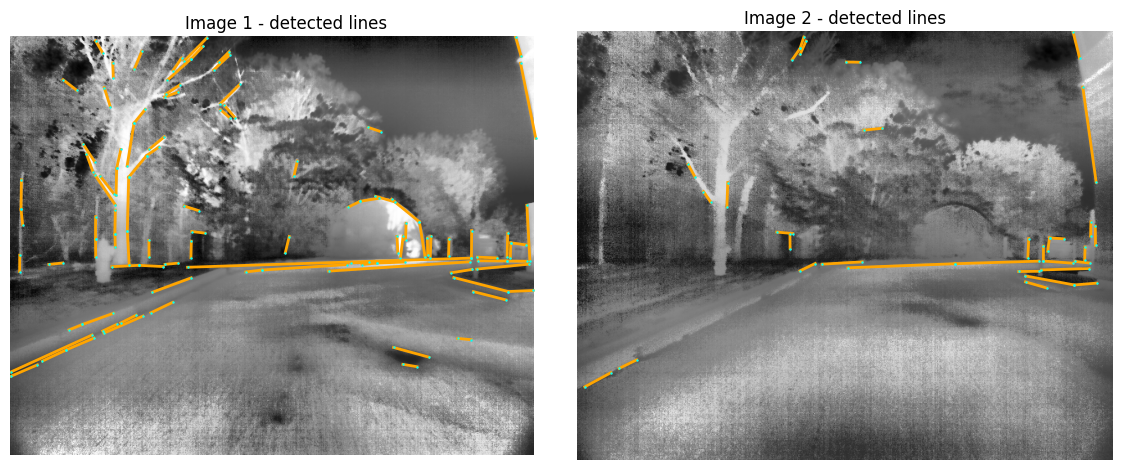

In [ ]:
img0, img1 = cv2.cvtColor(gray0, cv2.COLOR_GRAY2BGR), cv2.cvtColor(gray1, cv2.COLOR_GRAY2BGR)
plot_images([img0, img1], ['Image 1 - detected lines', 'Image 2 - detected lines'], pad=0.5)
# plot_lines([matched_lines0, matched_lines1], ps=3, lw=2)
# print(matched_lines0[2])
# print(matched_lines1[2])
plot_lines([line_seg0, line_seg1], ps=3, lw=2)

## Detected Points

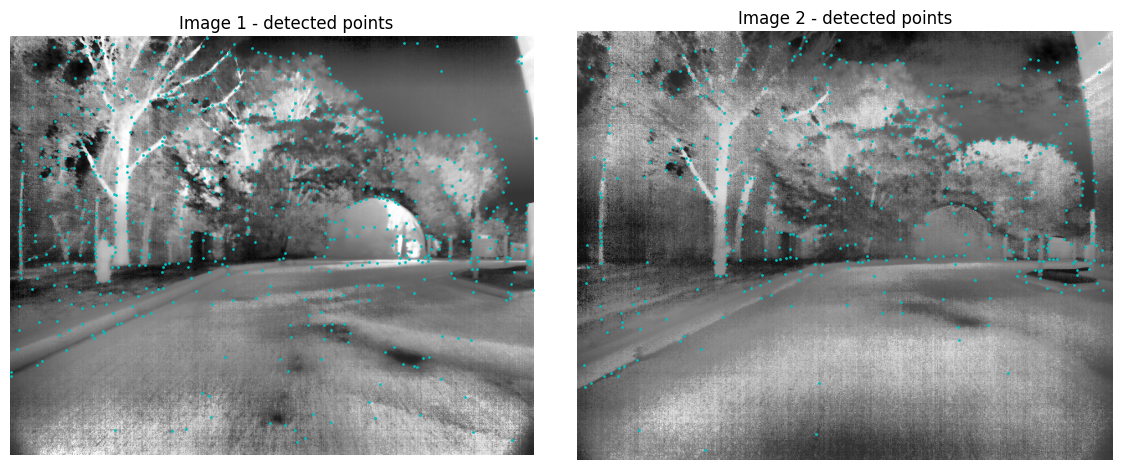

In [ ]:
plot_images([img0, img1], ['Image 1 - detected points', 'Image 2 - detected points'], pad=0.5)
plot_keypoints([kp0, kp1], colors='c')

## Matched Lines
(Each match has a different color)

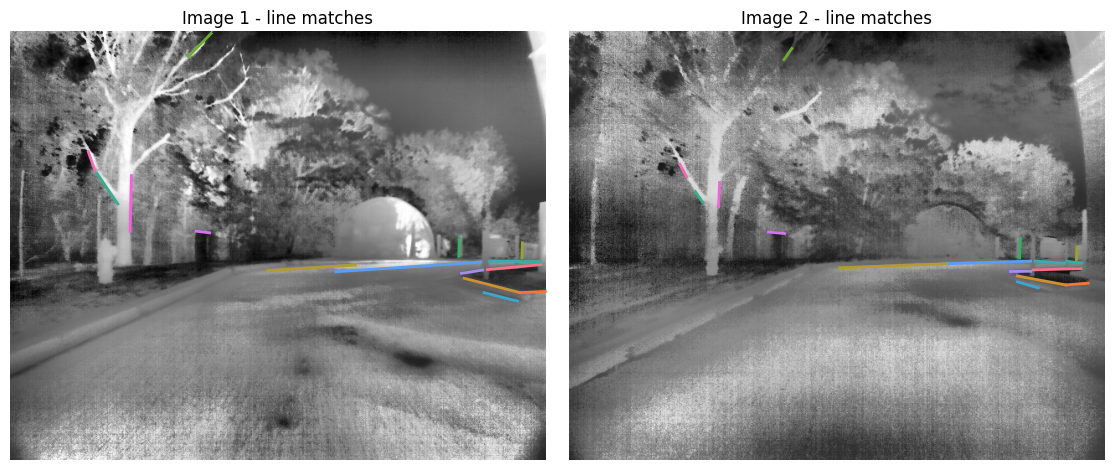

In [ ]:
plot_images([img0, img1], ['Image 1 - line matches', 'Image 2 - line matches'], pad=0.5)
plot_color_line_matches([matched_lines0, matched_lines1], lw=2)

## Matched Points

found 199 matched kps


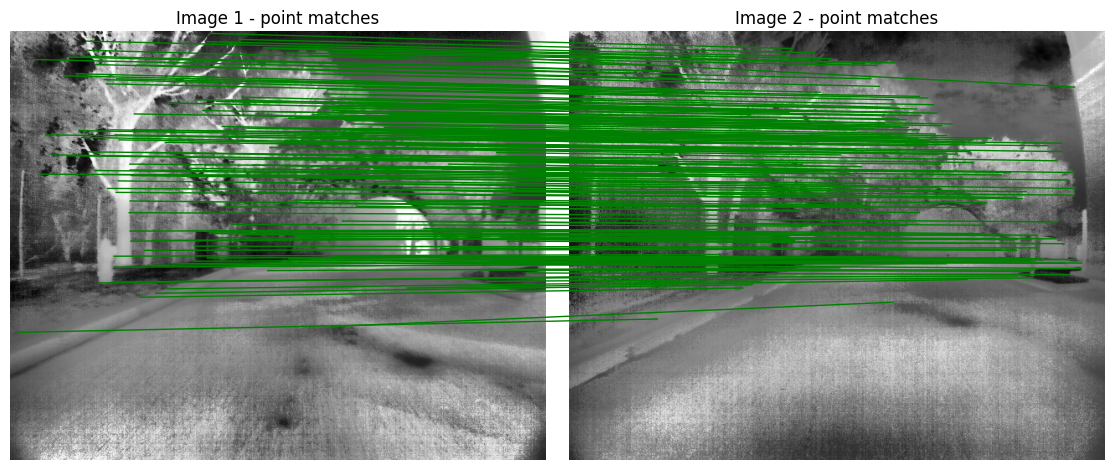

In [ ]:
plot_images([img0, img1], ['Image 1 - point matches', 'Image 2 - point matches'], pad=0.5)
plot_matches(matched_kps0, matched_kps1, 'green', lw=1, ps=0)
print("found {} matched kps".format(len(matched_kps0)))

# Homography estimation

If the scene is nearly a plane, we can estimate a robust homography using both, points and lines

In [ ]:
# !sudo apt-get update
# !sudo apt-get install -y libceres-dev libeigen3-dev
# !pip install git+https://github.com/rpautrat/homography_est.git@17b200d528e6aa8ac61a878a29265bf5f9d36c41

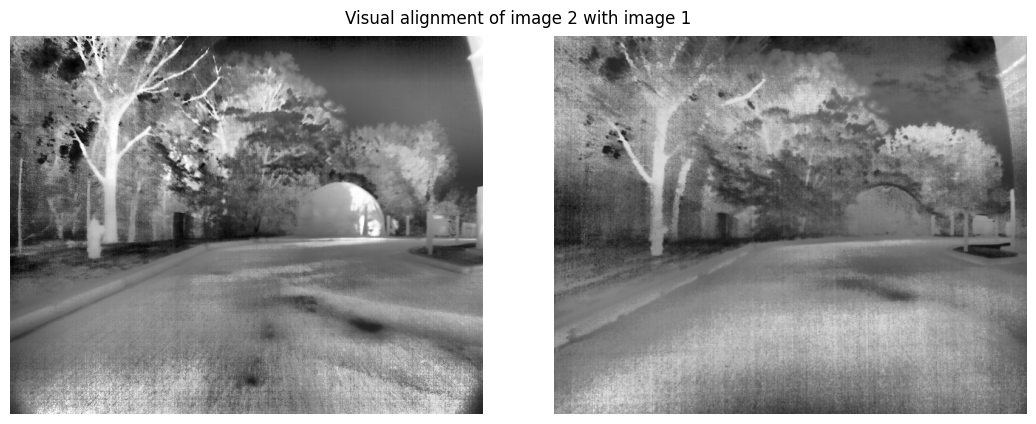

In [ ]:
import homography_est as hest

line_seg0 = [hest.LineSegment(l[0], l[1])
             for l in matched_lines0.reshape(-1, 2, 2)]
line_seg1 = [hest.LineSegment(l[0], l[1])
             for l in matched_lines1.reshape(-1, 2, 2)]

tol_px = 1.0
H = hest.ransac_point_line_homography(matched_kps0, matched_kps1, line_seg0, line_seg1, tol_px, False, [], [])

color0 = cv2.cvtColor(cv2.imread(img_path0), cv2.COLOR_BGR2RGBA)
color1 = cv2.cvtColor(cv2.imread(img_path1), cv2.COLOR_BGR2RGBA)

warped = cv2.warpPerspective(color1, H, color0.shape[:2][::-1])

plot_images([color0, warped], pad=2.6)
plt.suptitle('Visual alignment of image 2 with image 1')
plt.show()

We can check how well aligned are both images generating a nice transition GIF 😎

In [ ]:
# #@title GIF Generation
# import matplotlib.animation as animation
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm
# import sys
# from IPython.display import Video

# n_frames = 10
# # create samples distribution with different `std` values
# frames_indices = np.append(np.arange(n_frames), np.arange(n_frames)[::-1])
# pbar = tqdm(frames_indices, desc ="Generating animation", total=len(frames_indices)-1)
# # func which will be applied in order to create a video frame
# def func(i):
#     plt.gca().clear()
#     alpha = i / (n_frames - 1)
#     beta = (1.0 - alpha)
#     dst = cv2.addWeighted(color0, alpha, warped, beta, 0.0)
#     plt.gca().imshow(dst)
#     plt.axis('off')

# fig = plt.figure(figsize=(6, 6))
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
# # create the animation using custom func and its parameters (fargs)
# ani = animation.FuncAnimation(fig, func, pbar, interval=100,
#                               repeat_delay=250, blit=False)

# # save the animation into a specific video format
# dst_file = './animation_homography.mp4'
# ani.save(dst_file)
# plt.close()

# # custom html attributes set when lauching the video
# Video(dst_file, embed=True, html_attributes="muted loop autoplay")

BF found 258 matches
109 matches after ransac


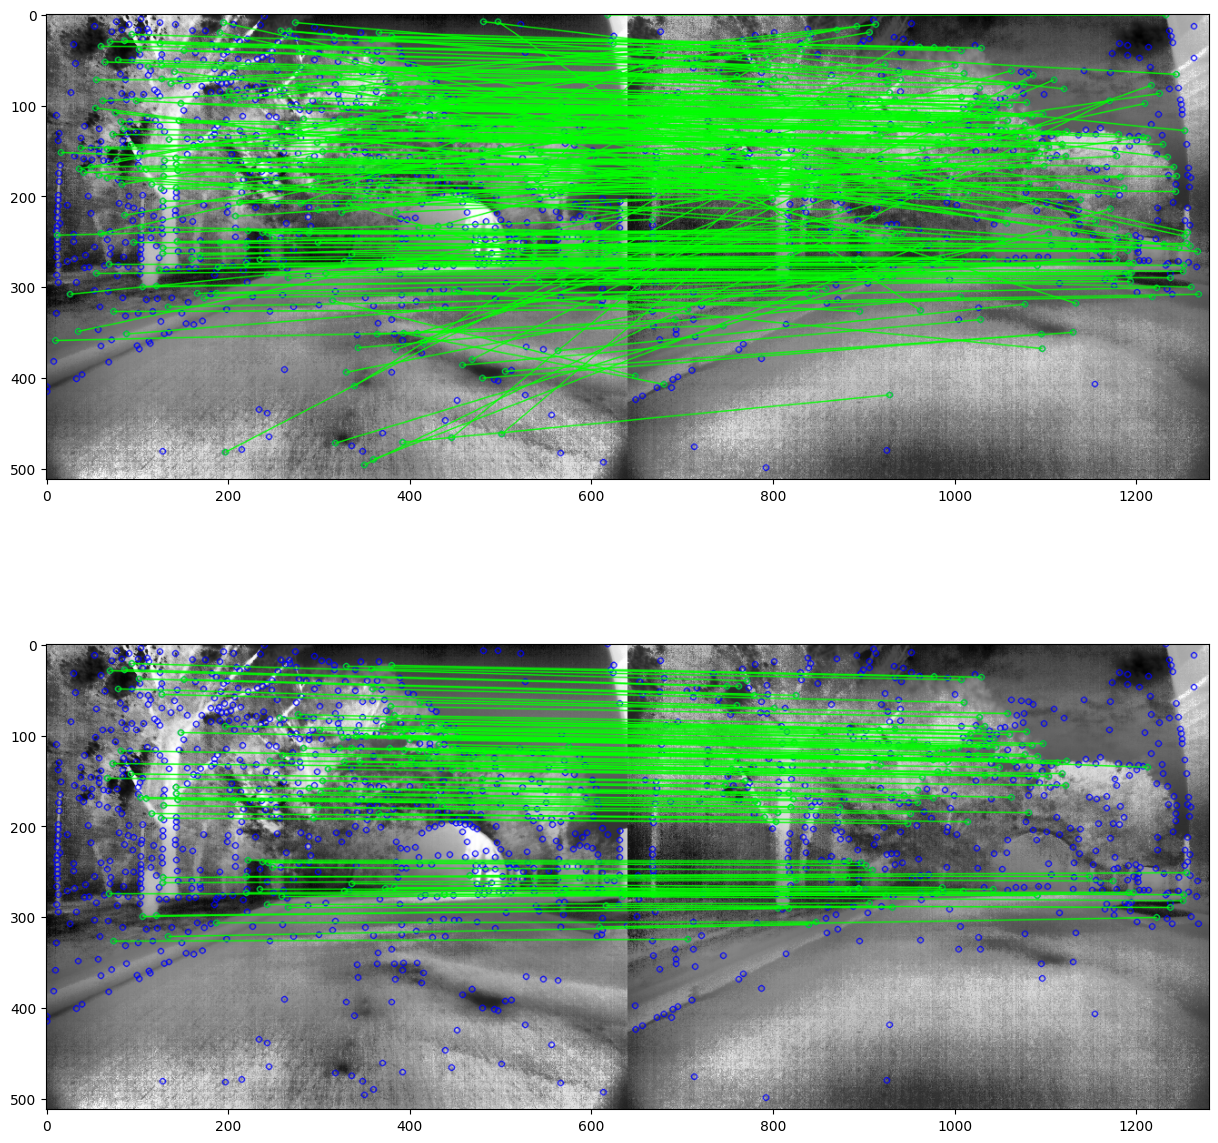

In [ ]:
import numpy as np
#cv2 bf matcher on matched kp
desc0, desc1 = pred['descriptors0'].T, pred['descriptors1'].T

# print(kp0.shape)
# print(desc0.shape)
keypoints0 = [cv2.KeyPoint(kp[0], kp[1], 1) for kp in kp0]
keypoints1 = [cv2.KeyPoint(kp[0], kp[1], 1) for kp in kp1]

# kpim = cv2.drawKeypoints(img0, keypoints0, None)
# plt.imshow(kpim)

bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(desc0, desc1)
print("BF found {} matches".format(len(matches)))
matched_img = cv2.drawMatches(img0, keypoints0, img1, keypoints1, matches,
                                    None, matchColor=(0, 255, 0),
                                    singlePointColor=(0, 0, 255))
matches_idx = np.array([m.queryIdx for m in matches])
m_kp0 = [keypoints0[idx] for idx in matches_idx]
matches_idx = np.array([m.trainIdx for m in matches])
m_kp1 = [keypoints1[idx] for idx in matches_idx]

matched_pts0 = cv2.KeyPoint_convert(m_kp0)
matched_pts1 = cv2.KeyPoint_convert(m_kp1)
# print(type(matched_pts1))
# matched_pts0 = np.array([[kp.pt[1], kp.pt[0]] for kp in m_kp0])
# matched_pts1 = np.array([[kp.pt[1], kp.pt[0]] for kp in m_kp1])
F, inliers = cv2.findFundamentalMat(matched_pts0[:, [1, 0]],
                                    matched_pts1[:, [1, 0]],
                                    cv2.RANSAC)
inliers = inliers.flatten()
print("{} matches after ransac".format(np.sum(inliers)))
inlier_matches = np.array(matches)[inliers.astype(bool)].tolist()
matched_img_ransac = cv2.drawMatches(img0, keypoints0, img1, keypoints1, inlier_matches,
                                    None, matchColor=(0, 255, 0),
                                    singlePointColor=(0, 0, 255))
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (15,15))
_= ax1.imshow(matched_img)
_ = ax2.imshow(matched_img_ransac)

In [ ]:
#test save descriptors
kp0 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/keypoints/1689804908243000031.npy" 
kp0 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/keypoints/1689804908309999943.npy"
kp1 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/keypoints/1689804908309999943_.npy"
desc0 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/descriptors/1689804908243000031.npy"
desc1 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/descriptors/1689804908309999943.npy"
# desc1 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/descriptors/1689804908309999943_.npy"
matches = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/matches/1689804908243000031_1689804908309999943.npy"
kp0 = np.load(kp0)
kp1 = np.load(kp1)
desc0 = np.load(desc0)
desc1 = np.load(desc1)
matches = np.load(matches)
print(kp0.shape)
print(desc0.shape)
print(kp1.shape)
print(desc1.shape)
print(matches.shape)
print("")
print(kp0[0])
count = 0
for kp in kp0:
    for k in kp1:
        if np.linalg.norm(k-kp) < 1:
            count += 1
            continue
print("Found {} similar points".format(count))

plot_images([img0, img1], ['Image 1 - line matches', 'Image 2 - line matches'], pad=0.5)
plot_keypoints([kp0, kp1], colors='c')

FileNotFoundError: [Errno 2] No such file or directory: '/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/keypoints/1689804908309999943.npy'

In [ ]:
# import time
# desc1 = torch.rand((1,256), dtype = torch.float32).to('cuda')
# desc2 = torch.rand((1,256), dtype = torch.float32).to('cuda')
# # desc1.device
# n_samples = 10_000_000
# print("timing sp for {} distance calcualtions".format(n_samples))
# start_time = time.time()
# for _ in range(n_samples):
#     dist = torch.linalg.vector_norm(desc1-desc2)
#     # dist = ((desc1 - desc2)**2).sum()
# end_time = time.time()
# print("total time = {}".format(end_time - start_time))



In [ ]:
#shape = (lines,endpoints,256)
l = 3
e = 2
d = 10
a = np.array(range(l*e*d)).reshape(l,e,d)
print(a)
print(a.shape)
n = np.linalg.norm(a, axis = -1)
print(n)
print(n.shape)
a_norm = a/n.reshape(-1,2,1)
# a_norm = a/n.reshape(3,2,1)
print(a_norm)
# m = np.mean(a, axis = -1)
# print(m)

In [ ]:
desc_s1 = "/media/colin/box_data/ir_data/nuance_data/columbus_garrage_day_night/garrage_roof_nuance_jul14_10pm/cam_3/matlab_clahe2/gluestick_freq2/matched_descriptors/1689388619484999895.npy"
desc_s2 = "/media/colin/box_data/ir_data/nuance_data/columbus_garrage_day_night/garrage_roof_nuance_jul14_10pm/cam_3/matlab_clahe2/gluestick_freq2/matched_descriptors/1689388619552000046_.npy"
desc_s1 = np.load(desc_s1)
desc_s2 = np.load(desc_s2)
print("mean dist:")
dist = np.linalg.norm(desc_s1-desc_s2, axis = -1)
print(np.mean(dist))
print(dist.shape)
print(desc_s1.shape)
print(desc_s2.shape)

print("mean_desc")
mean_desc = (desc_s1+desc_s2)/2
mean_desc /= np.linalg.norm(mean_desc, axis = -1).reshape(-1,1)
norm = np.linalg.norm(mean_desc, axis = -1).reshape(-1,1)
print(mean_desc.shape)
print(norm.shape)
print(np.min(norm))
print(np.argmin(norm))

m_dist = np.linalg.norm(mean_desc-desc_s2, axis = -1)
print("mean dist to average:")
print(np.mean(m_dist))

In [ ]:
a = np.array([0])
with np.errstate(divide='raise',invalid='raise'):
    try:
        a / 0   # this gets caught and handled as an exception
    except FloatingPointError:
        print('oh no!')
b = a / 0           # this prints a RuntimeWarning as usual
np.isnan(a)
np.any(np.isnan(b))